## FC for Widespread Pain Subjects
#### Input: *stc.mat
####  Output: con, visualization

In [1]:
import os
from pathlib import Path
import sys
import mne 
import numpy as np
from mne.datasets import fetch_fsaverage
from tabulate import tabulate
fs_dir = fetch_fsaverage(verbose=True)
subject = "fsaverage"
subjects_dir = os.path.dirname(fs_dir)
sys.path.append("/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/")
from eeg_toolkit import preprocess, utils
import eeg_toolkit.functional_connectivity as fc

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


### Paths

In [2]:
# sl_method = input("Source Localization Method (1- MNE or 2- dSPM): ")
# sl_method = 'MNE' if sl_method == '1' else 'dSPM'
# sl_method = 'dSPM'
sl_method = 'MNE'

In [3]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / f"Source Time Courses ({sl_method})"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
fc_path = data_dir / f"Functional Connectivity ({sl_method})"
fc_subset_path = fc_path / subset
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Get subset of subjects with and without widespread pain

### Manually enter age/sex matched subjects

In [4]:
# All CP and HC subs
sub_ids = [  
    '018',  
    '020',  
    '021',  
    '027',  
    '031',  
    '032',  
    '033',  
    '035',  
    '036',  
    '037',  
    '038',  
    '040',  
    '043',  
    '044',  
    '048',  
    '049',  
    '050',  
    '057',  
    '059',  
    'C10',  
    'C11',  
    'C12',  
    'C13',  
    'C14',  
    'C15',  
    'C16',  
    'C17',  
    'C18',  
    'C19',  
    'C2.',  
    'C24',  
    'C25',  
    'C26',  
    'C27',  
    'C3.',  
    'C6.',  
    'C7.',  
    'C9.'  
]  

# TODO: temporary-- These subjects have no keypresses and thus no resting timestamps, but they do have epoched data
NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids = [sub for sub in sub_ids if sub not in NO_KEYPRESS]

# CP Subs with widespread pain
sub_ids_CP_WSP = [
    '018',
    '022',
    '024',
    '031',
    '032',
    '034',
    '036',
    '039',
    '040',
    # '045', # TODO: add back in when timestamps ready
    '046',
    '052',
]

# CP Subs with localized pain
sub_ids_CP_LP = [  
    '020',  
    '021',  
    '023',  
    '029',  
    '031',  
    '037',  
    '041',  
    '042',  
    '048',  
    '049',  
    '050',  
    '056'  
]  

# Split CP and HC
sub_ids_CP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

In [5]:
# # viable subjects
# sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
# sub_ids = sorted(sub_ids[7:])  # select only 64ch subs and turn into set

# Exclude HEALTHY subjects with widespread pain
widespread_pain_HC = ['C1.','C23']
sub_ids_HC = [sub for sub in sub_ids_HC if sub not in widespread_pain_HC]

# Exclude subjects with low trial count
# TODO: figure out how to skip
# C5 i think missing resting but has X trials
# sub_ids_CP_WSP.remove('055') 
# 036 has 6; 037 has 6, 044 has 5, 056 has 5, 058 has 4 (Localized pain)
# sub_ids_CP_LP.remove(['036', '037', '044', '056', '058'])

In [6]:
print(f"Chronics (all): {len(sub_ids_CP)}")
print([el for el in sub_ids_CP])
print(f"Chronics with widespread pain: {len(sub_ids_CP_WSP)}")
print([el for el in sub_ids_CP_WSP])
print(f"Chronics with localized pain: {len(sub_ids_CP_LP)}")
print([sub for sub in sub_ids_CP_LP])
print(f"Controls: {len(sub_ids_HC)}")
print([el for el in sub_ids_HC])
print(f"\nTotal (Chronics + Controls): {len(sub_ids)}")


Chronics (all): 19
['018', '020', '021', '027', '031', '032', '033', '035', '036', '037', '038', '040', '043', '044', '048', '049', '050', '057', '059']
Chronics with widespread pain: 11
['018', '022', '024', '031', '032', '034', '036', '039', '040', '046', '052']
Chronics with localized pain: 12
['020', '021', '023', '029', '031', '037', '041', '042', '048', '049', '050', '056']
Controls: 19
['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2.', 'C24', 'C25', 'C26', 'C27', 'C3.', 'C6.', 'C7.', 'C9.']

Total (Chronics + Controls): 38


### Settings for conditions/bands/methods

In [7]:
# Settings
sfreq = 400  # Hz
tmin, tmax = 0.0, 1.25  # exclude the baseline period for connectivity estimation

# Use canonical bands or narrower bands
narrow_bands = False 
# narrow_bands = True 

# Choose which connectivity estimates to run. "amplitude", "phase", or "both"
method_choice = "phase"
# method_choice = "both"

# Include intermediate stimulus?
include_LS = False

# Load previously saved group data
load_group_data_flag = False
# load_group_data_flag = True

# Save group data?
save_group_data_flag = True
# save_group_data_flag = False

# Evoked only or include resting too?
# include_resting = True
include_resting = False

### Define ROIs, frequency bands, conditions, and methods for FC

In [8]:
####################################################################
# REGIONS OF INTEREST
roi_names = [  # Left
    "rostralanteriorcingulate-lh",  # Left Rostral ACC
    "caudalanteriorcingulate-lh",  # Left Caudal ACC
    "postcentral-lh",  # Left S1,
    "insula-lh",
    "superiorfrontal-lh",  # Left Insula, Left DL-PFC,
    "medialorbitofrontal-lh",  # Left Medial-OFC
    # Right
    "rostralanteriorcingulate-rh",  # Right Rostral ACC
    "caudalanteriorcingulate-rh",  # Right Caudal ACC
    "postcentral-rh",  # , Right S1
    "insula-rh",
    "superiorfrontal-rh",  # Right Insula, Right DL-PFC
    "medialorbitofrontal-rh",
]  # Right Medial-OFC

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "dACC-lh", "S1-lh", "insula-lh", "dlPFC-lh", "mOFC-lh",
                "rACC-rh", "dACC-rh", "S1-rh", "insula-rh", "dlPFC-rh", "mOFC-rh"]


####################################################################
# BANDS OF INTEREST
if not narrow_bands:
    Freq_Bands = {
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        # "alpha": [8.0, 13.0],
        # "beta": [13.0, 30.0],
        # "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        # "high-gamma": [61.5, 100.0],
    }
else:
    Freq_Bands = { # Narrower bands and overlaps
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        "low-alpha": [6.0, 12.0],
        "high-alpha": [10.0, 15.0],
        # "low-beta": [12.0, 22.0],
        # "high-beta": [20.0, 32.0],
        "low-gamma-i": [28.0, 46.0],
        "low-gamma-ii": [44.0, 58.5],
        # # "notch": [58.5, 61.5],
        "high-gamma-i": [61.5, 82.0],
        "high-gamma-ii": [80.0, 100.0],
    }
band_names = [band for band in Freq_Bands]

####################################################################
# CONNECTIVITY METHODS
if method_choice == "phase":
    con_methods = ["wpli2_debiased",
                ]
elif method_choice == "amplitude":
    con_methods = [
        # "aec_pairwise",
        "aec_symmetric",
        ]
elif method_choice == "both":
    con_methods = [
    "wpli2_debiased",
    # "aec_pairwise",
    "aec_symmetric", # keep only symmetric for now
    ]
    
####################################################################
# CONDITIONS
conditions = (
    [
        "Hand 32 mN",
        "Hand 128 mN",
        "Hand 256 mN",
        "Back 32 mN",
        "Back 128 mN",
        "Back 256 mN",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        # "Hand 32 mN",
        # 'Hand LS',
        "Hand 256 mN",
        # "Back 32 mN",
        # 'Back LS',
        # "Back 256 mN",
        "Eyes Open",
        # "Eyes Closed",
    ]
)

# Choose to exclude resting state data
conditions = conditions if include_resting else [
    c for c in conditions if "Eyes" not in c
]

####################################################################
# CONDITION DICTIONARY
condition_dict = {
        "Hand 32 mN": 0,
        'Hand LS': 1,
        "Hand 256 mN": 2,
        "Back 32 mN": 3,
        'Back LS': 4,
        "Back 256 mN": 5,
        "Eyes Open": 6,
        "Eyes Closed": 7,
}

####################################################################
# GROUP NAMES
groups=['Chronic Pain with Widespread Pain','Chronic Pain', 'Healthy Control']

### Compute functional connectivity for each subject in each group

In [9]:
# Healthy Control group
if not load_group_data_flag:
    sub_con_HC = {}
    for sub_id in sub_ids_HC:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Healthy Control",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_HC[sub_id] = sub_avg_cons
    utils.clear_display()

C10
Reading stimulus labels and pain ratings for Subject C10...

*stim_labels length = 57*
*pain_ratings_raw length = 57*

+----------------+----------------+
| Subject        | C10            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:158: RuntimeWarning: stop time tmax=1.25 s outside of the time scope of the data [0.00 s, 1.00 s]
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:158: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
C3.
Reading stimulus labels and pain ratings for Subject C3....

*stim_labels length = 76*
*pain_ratings_raw length = 76*

+----------------+----------------+
| Subject        | C3.            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation 

In [10]:
# Chronics (all) group
if not load_group_data_flag:
    sub_con_CP = {}
    for sub_id in sub_ids_CP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_CP[sub_id] = sub_avg_cons
    utils.clear_display()

018
Reading stimulus labels and pain ratings for Subject 018...

*stim_labels length = 73*
*pain_ratings_raw length = 73*

+----------------+----------------+
| Subject        | 018            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

In [11]:
# CLBP with WSP
if not load_group_data_flag:
    sub_con_CP_WSP = {}
    for sub_id in sub_ids_CP_WSP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain w/ WSP",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_CP_WSP[sub_id] = sub_avg_cons
        
    utils.clear_display()

018
Reading stimulus labels and pain ratings for Subject 018...

*stim_labels length = 73*
*pain_ratings_raw length = 73*

+----------------+----------------+
| Subject        | 018            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

In [26]:
# CLBP with LP
if not load_group_data_flag:
    sub_con_CP_LP = {}
    for sub_id in sub_ids_CP_LP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain w/ Localized Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_CP_LP[sub_id] = sub_avg_cons
        
    utils.clear_display()

020
Reading stimulus labels and pain ratings for Subject 020...

*stim_labels length = 80*
*pain_ratings_raw length = 80*

+----------------+----------------+
| Subject        | 020            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.250s for estimation (501 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:158: RuntimeWarning: stop time tmax=1.25 s outside of the time scope of the data [0.00 s, 1.00 s]
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:158: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


In [13]:
if not load_group_data_flag:
    # Stack the connectivity of all subjects in each group
    group_con_HC = fc.compute_group_con(sub_con_HC, conditions, con_methods, band_names)
    group_con_CP = fc.compute_group_con(sub_con_CP, conditions, con_methods, band_names)
    group_con_CP_WSP = fc.compute_group_con(sub_con_CP_WSP, conditions, con_methods, band_names)
    group_con_CP_LP = fc.compute_group_con(sub_con_CP_LP, conditions, con_methods, band_names)
else:
    group_con_HC = utils.unpickle_data(save_path, f"group_con_{subset}_HC.pkl")
    group_con_CP = utils.unpickle_data(save_path, f"group_con_{subset}_CP.pkl")
    group_con_CP_WSP = utils.unpickle_data(save_path, f"group_con_{subset}_CP_WSP.pkl")
    group_con_CP_LP = utils.unpickle_data(save_path, f"group_con_{subset}_CP_LP.pkl")

    sub_con_HC = utils.unpickle_data(save_path, f"sub_con_{subset}_HC.pkl")
    sub_con_CP = utils.unpickle_data(save_path, f"sub_con_{subset}_CP.pkl")
    sub_con_CP_WSP = utils.unpickle_data(save_path, f"sub_con_{subset}_CP_WSP.pkl")
    sub_con_CP_LP = utils.unpickle_data(save_path, f"sub_con_{subset}_CP_LP.pkl")

In [14]:
if save_group_data_flag:
    # Save/checkpoint as pickle
    utils.pickle_data(save_path, f"sub_con_{subset}_HC.pkl", sub_con_HC)
    utils.pickle_data(save_path, f"group_con_{subset}_HC.pkl", group_con_HC)
    
    utils.pickle_data(save_path, f"sub_con_{subset}_CP.pkl", sub_con_CP)
    utils.pickle_data(save_path, f"group_con_{subset}_CP.pkl", group_con_CP)
    
    utils.pickle_data(save_path, f"sub_con_{subset}_CP_WSP.pkl", sub_con_CP_WSP)
    utils.pickle_data(save_path, f"group_con_{subset}_CP_WSP.pkl", group_con_CP_WSP)

    utils.pickle_data(save_path, f"sub_con_{subset}_CP_LP.pkl", sub_con_CP_LP)
    utils.pickle_data(save_path, f"group_con_{subset}_CP_LP.pkl", group_con_CP_LP)

Saved sub_con_Widespread_Pain_HC.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain.
Saved group_con_Widespread_Pain_HC.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain.
Saved sub_con_Widespread_Pain_CP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain.
Saved group_con_Widespread_Pain_CP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain.
Saved sub_con_Widespread_Pain_CP_WSP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain.
Saved group_con_Widespread_Pain_CP_WSP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain.
Saved sub_con_Widespread_Pain_CP_LP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain.
Saved group_con_Widespread_Pain_CP_LP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain.


### Plot settings

### Plot and compute satistics to assess statistical differences 

In [21]:
# Highlight p-values with red box automatically
highlight_pvals=False

# Make any non-significant squares white
show_only_significant=True

# Set a minimum value for the functional connectivity (for sub zero values)
min_fc_val=None

# Set title automatically
set_title=True

# Show values in the matrix quadrants
show_fc_vals=True

# Round negative values to zero
round_neg_vals=True

# Plot 3D brain visualization (for AEC only)
plot_brain=False

Hand 256 mN - Chronic Pain vs. Healthy Control - wpli2_debiased - theta
Top 3 Connections in Chronic Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| dACC-rh <-> dACC-lh  |     4     |     0.505     |
| mOFC-rh <-> dlPFC-lh |     3     |     0.479     |
| dlPFC-rh <-> dACC-lh |     3     |     0.384     |
+----------------------+-----------+---------------+
Top 3 Connections in Healthy Control group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  mOFC-rh <-> rACC-rh  |     3     |     0.44      |
|  mOFC-rh <-> rACC-lh  |     2     |     0.443     |
| dlPFC-rh <-> dlPFC-lh |     2     |     0.336     |
+-----------------------+-----------+---------------+
Num epochs: 209 vs. 212


+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
|   S1-rh <-> dACC-lh   |  0.01   | 0.015 ± 0.008  | 0.138 ± 0.046  |
| dlPFC-rh <-> dlPFC-lh |  0.041  | 0.033 ± 0.018  |  0.1 ± 0.029   |
+-----------------------+---------+----------------+----------------+


<Figure size 640x480 with 0 Axes>

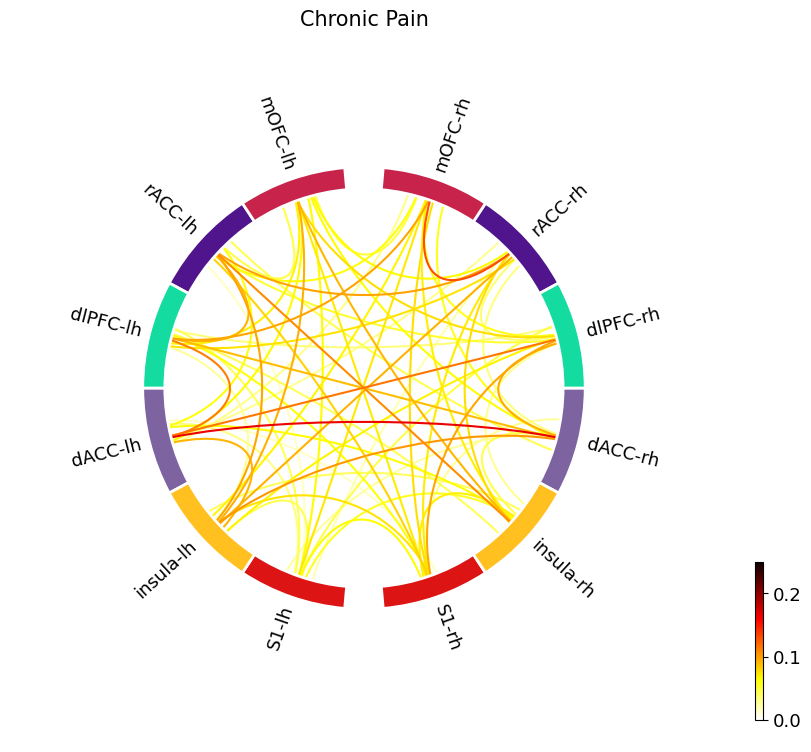

<Figure size 640x480 with 0 Axes>

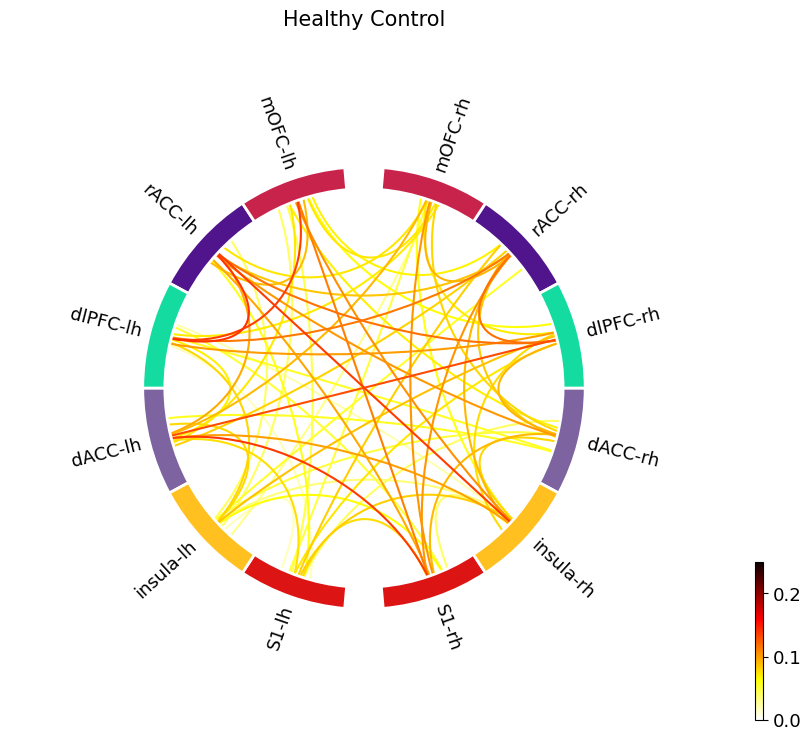

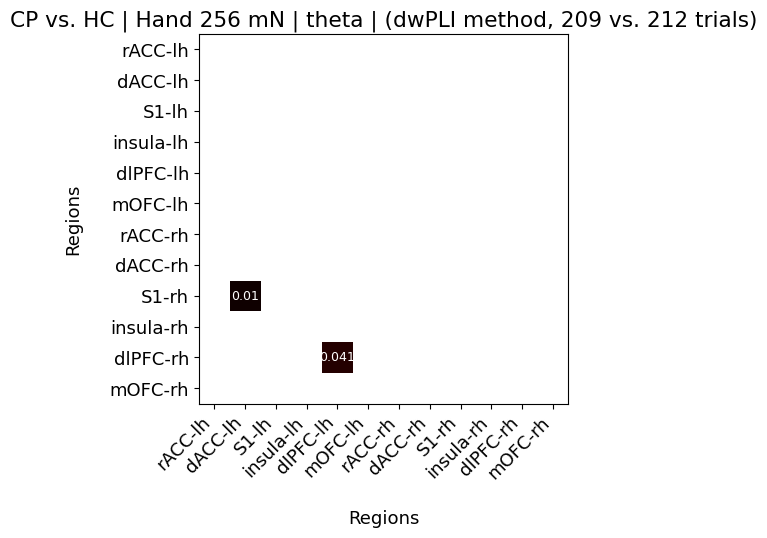

In [22]:
# CP Widespread Pain Hand HS. vs Healthy Control Hand HS
these_group_names = ["Chronic Pain", "Healthy Control","Mann_Whitney_U_test"]
these_group_cons = [group_con_CP, group_con_HC]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_vs_HC_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")

            # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
            for group_con,group_name in zip(these_group_cons, these_group_names):
                table_data = []  
                top_3_info = group_con[condition][method][band]["top 3"] 
                print(f"Top 3 Connections in {group_name} group")
                for i in range(3):  
                    connection = top_3_info["connections"][i]  
                    frequency = top_3_info["frequency"][i]  
                    mean_strength = top_3_info["mean strength"][i]  
                    table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", frequency, mean_strength])  
                
                # Define table headers  
                headers = ['Connection', 'Frequency', 'Mean Strength']  
                
                # Print the table  
                print(tabulate(table_data, headers, tablefmt='pretty'))  

            group1_stack = these_group_cons[0][condition][method][band]["data"]
            group2_stack = these_group_cons[1][condition][method][band]["data"]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            print(f"Num epochs: {nepochs_1} vs. {nepochs_2}")

            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names,method=method)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_names,
                roi_acronyms=roi_acronyms,
                condition=condition,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=[these_group_names[0], 
                        these_group_names[1],
                        "CP vs. HC",],
                save_names=["Mann_Whitney_U_test",
                            these_group_names[0], 
                            these_group_names[1],
                            ],
                save_path=stats_save_path,
                )           

            fc.plot_connectivity_and_stats(means_1=means_1,
                                           means_2=means_2,
                                           sem_1=sem_1,
                                           sem_2=sem_2,
                                           p_values=p_values,
                                           **plot_kwargs,
                                           save_fig=True,
                                           highlight_pvals=highlight_pvals,
                                           min_fc_val=min_fc_val,
                                           set_title=set_title,
                                           show_fc_vals=show_fc_vals,
                                           round_neg_vals=round_neg_vals,
            )
            
            if "aec" in method and plot_brain:
                # Convert ROI names to labels
                labels = [
                    mne.read_labels_from_annot(
                        subject, regexp=roi, subjects_dir=subjects_dir
                    )[0]
                    for roi in roi_names
                ]

                # Load the inverse1
                inv = None
                if "Eyes" not in condition:
                    inv = utils.unpickle_data(
                        zscored_epochs_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Open":
                    inv = utils.unpickle_data(
                        EO_resting_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Closed":
                    inv = utils.unpickle_data(
                        EC_resting_data_path, f"{sub_id}_inv.pkl"
                    )

                fc.plot_degree(
                    p_values, 
                    title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_1, 
                    title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_2, 
                    title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> rACC-lh |     3     |     0.285     |
| dlPFC-rh <-> dACC-lh  |     2     |     0.266     |
|   rACC-rh <-> S1-lh   |     2     |     0.375     |
+-----------------------+-----------+---------------+
Top 3 Connections in CP with Localized Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| mOFC-rh <-> rACC-rh  |     4     |     0.547     |
| dACC-rh <-> dlPFC-lh |     3     |     0.572     |
| dACC-rh <-> dACC-lh  |     3     |     0.383     |
+----------------------+-----------+---------------+
Num epochs: 116 vs. 132
+-----------------------+---------+-----

<Figure size 640x480 with 0 Axes>

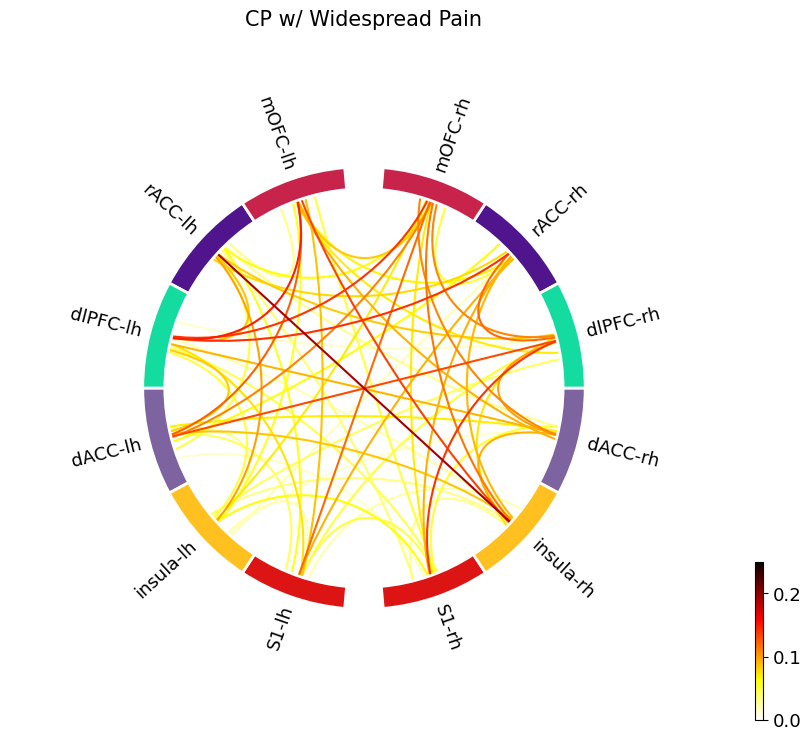

<Figure size 640x480 with 0 Axes>

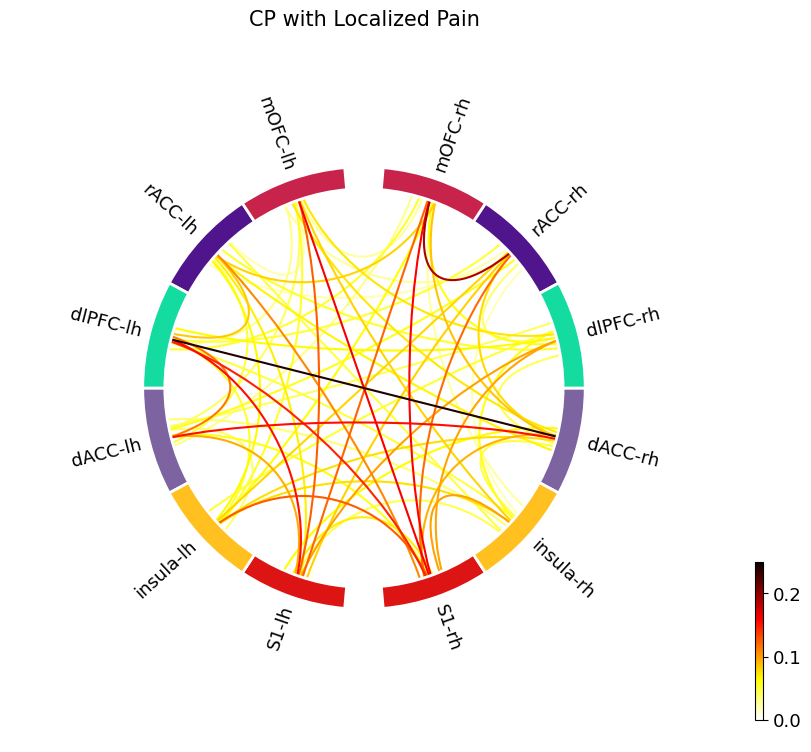

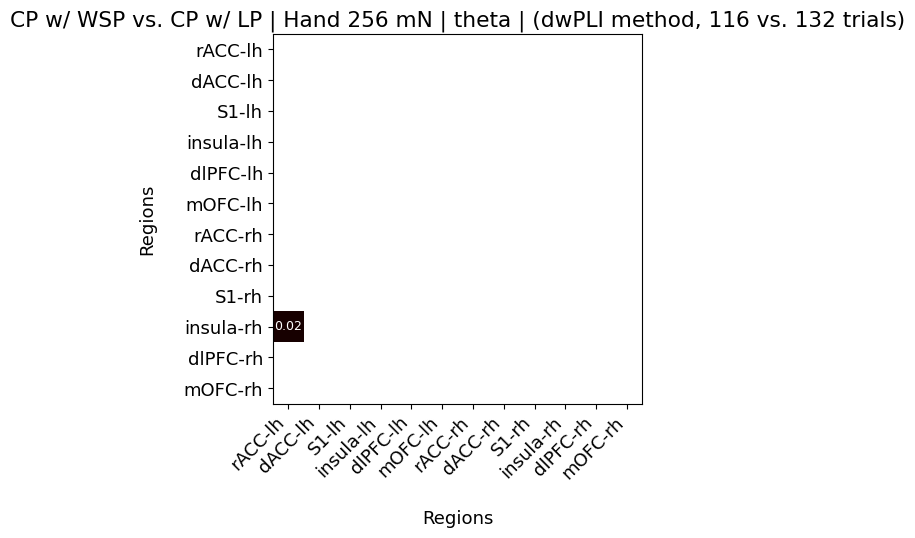

In [23]:
# CP Widespread Pain Hand HS. vs CP without Widespread Pain
these_group_names = ["CP w/ Widespread Pain", "CP with Localized Pain","Mann_Whitney_U_test"]
these_group_cons = [group_con_CP_WSP, group_con_CP_LP]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_vs_CP_LP_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")

            # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
            for group_con,group_name in zip(these_group_cons, these_group_names):
                table_data = []  
                top_3_info = group_con[condition][method][band]["top 3"] 
                print(f"Top 3 Connections in {group_name} group")
                for i in range(3):  
                    connection = top_3_info["connections"][i]  
                    frequency = top_3_info["frequency"][i]  
                    mean_strength = top_3_info["mean strength"][i]  
                    table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", frequency, mean_strength])  
                
                # Define table headers  
                headers = ['Connection', 'Frequency', 'Mean Strength']  
                
                # Print the table  
                print(tabulate(table_data, headers, tablefmt='pretty'))  

            group1_stack = these_group_cons[0][condition][method][band]["data"]
            group2_stack = these_group_cons[1][condition][method][band]["data"]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            print(f"Num epochs: {nepochs_1} vs. {nepochs_2}")
            
            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names,method=method)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_names,
                roi_acronyms=roi_acronyms,
                condition=condition,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=[these_group_names[0], 
                        these_group_names[1],
                        "CP w/ WSP vs. CP w/ LP",],
                save_names=["Mann_Whitney_U_test",
                            these_group_names[0], 
                            these_group_names[1],
                            ],
                save_path=stats_save_path,
                )
                                
            fc.plot_connectivity_and_stats(means_1=means_1,
                                           means_2=means_2,
                                           sem_1=sem_1,
                                           sem_2=sem_2,
                                           p_values=p_values,
                                           **plot_kwargs,
                                           save_fig=True,
                                           highlight_pvals=highlight_pvals,
                                           min_fc_val=min_fc_val,
                                           set_title=set_title,
                                           show_fc_vals=show_fc_vals,
                                           round_neg_vals=round_neg_vals,
            )

            if "aec" in method and plot_brain:
                # Convert ROI names to labels
                labels = [
                    mne.read_labels_from_annot(
                        subject, regexp=roi, subjects_dir=subjects_dir
                    )[0]
                    for roi in roi_names
                ]

                # Load the inverse
                inv = None
                if "Eyes" not in condition:
                    inv = utils.unpickle_data(
                        zscored_epochs_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Open":
                    inv = utils.unpickle_data(
                        EO_resting_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Closed":
                    inv = utils.unpickle_data(
                        EC_resting_data_path, f"{sub_id}_inv.pkl"
                    )

                fc.plot_degree(
                    p_values, 
                    title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_1, 
                    title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_2, 
                    title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )

## Plot individual data in each group

### Plot settings

Hand 256 mN - 018 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+----------------------+----------+
|      Connection      | Strength |
+----------------------+----------+
| rACC-rh <-> dlPFC-lh |  0.752   |
| mOFC-rh <-> dlPFC-lh |  0.746   |
| mOFC-lh <-> dlPFC-lh |  0.702   |
+----------------------+----------+
Num epochs: 20
+----------------------+----------------+
|       ROI Pair       | {method} Value |
+----------------------+----------------+
| rACC-rh <-> dlPFC-lh |     0.752      |
| mOFC-rh <-> dlPFC-lh |     0.746      |
| mOFC-lh <-> dlPFC-lh |     0.702      |
+----------------------+----------------+


<Figure size 640x480 with 0 Axes>

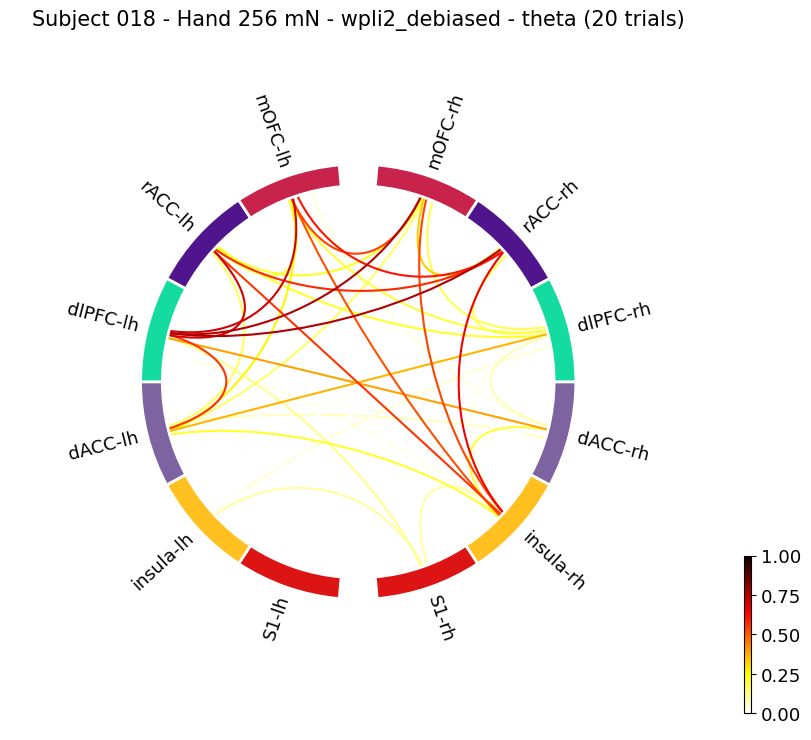

Hand 256 mN - 022 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+-----------------------+----------+
|      Connection       | Strength |
+-----------------------+----------+
| insula-rh <-> dACC-lh |  0.515   |
| insula-rh <-> dACC-rh |  0.444   |
| insula-rh <-> rACC-lh |  0.329   |
+-----------------------+----------+
Num epochs: 10
+-----------------------+----------------+
|       ROI Pair        | {method} Value |
+-----------------------+----------------+
| insula-rh <-> dACC-lh |     0.515      |
| insula-rh <-> dACC-rh |     0.444      |
| insula-rh <-> rACC-lh |     0.329      |
+-----------------------+----------------+


<Figure size 640x480 with 0 Axes>

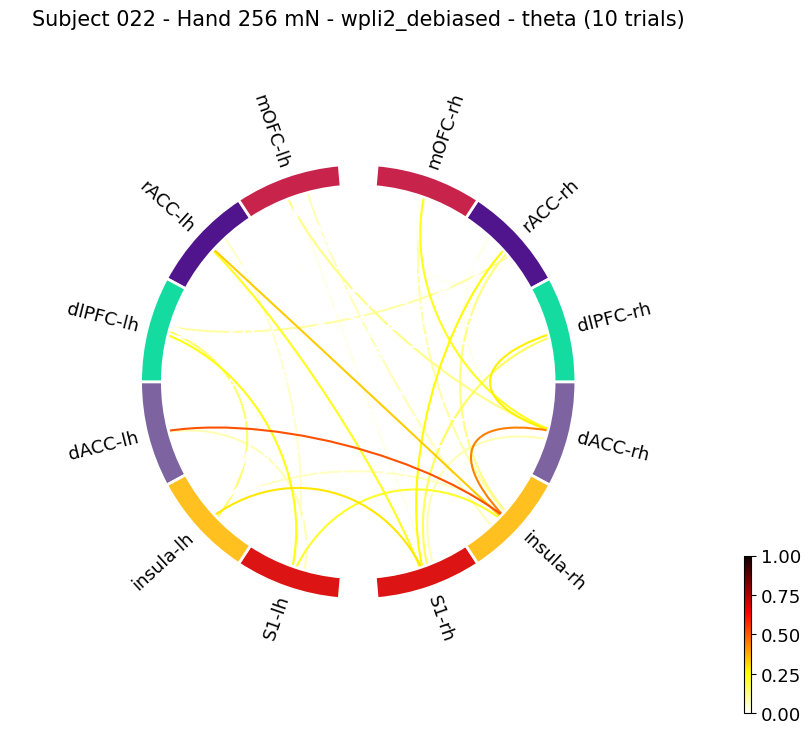

Hand 256 mN - 024 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+----------------------+----------+
|      Connection      | Strength |
+----------------------+----------+
| mOFC-rh <-> dlPFC-rh |  0.707   |
|  S1-rh <-> dACC-rh   |  0.444   |
| mOFC-lh <-> dACC-lh  |  0.411   |
+----------------------+----------+
Num epochs: 10
+----------------------+----------------+
|       ROI Pair       | {method} Value |
+----------------------+----------------+
| mOFC-rh <-> dlPFC-rh |     0.707      |
|  S1-rh <-> dACC-rh   |     0.444      |
| mOFC-lh <-> dACC-lh  |     0.411      |
+----------------------+----------------+


<Figure size 640x480 with 0 Axes>

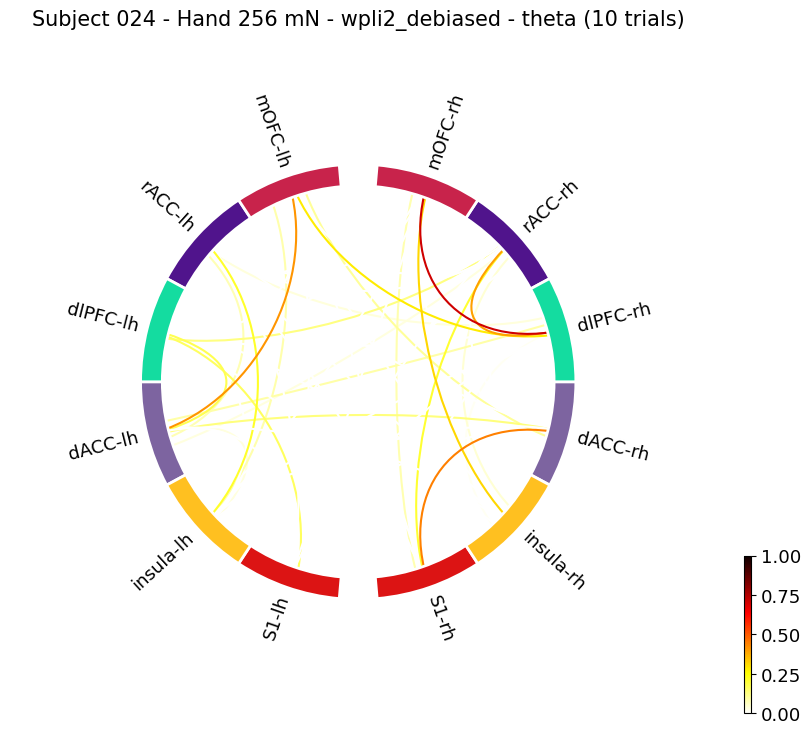

Hand 256 mN - 031 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+----------------------+----------+
|      Connection      | Strength |
+----------------------+----------+
| dlPFC-rh <-> dACC-lh |  0.256   |
|  S1-rh <-> mOFC-lh   |  0.227   |
| dACC-rh <-> dACC-lh  |   0.2    |
+----------------------+----------+
Num epochs: 10
+----------------------+----------------+
|       ROI Pair       | {method} Value |
+----------------------+----------------+
| dlPFC-rh <-> dACC-lh |     0.256      |
|  S1-rh <-> mOFC-lh   |     0.227      |
| dACC-rh <-> dACC-lh  |      0.2       |
+----------------------+----------------+


<Figure size 640x480 with 0 Axes>

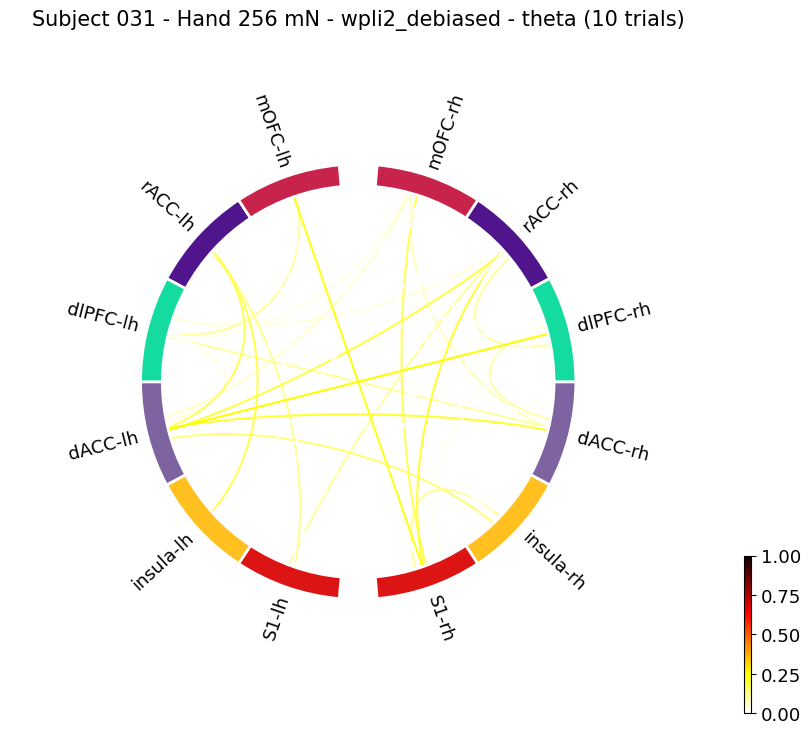

Hand 256 mN - 032 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+---------------------+----------+
|     Connection      | Strength |
+---------------------+----------+
|  mOFC-rh <-> S1-lh  |  0.686   |
| dACC-rh <-> mOFC-lh |  0.669   |
| mOFC-rh <-> dACC-rh |  0.618   |
+---------------------+----------+
Num epochs: 7
+---------------------+----------------+
|      ROI Pair       | {method} Value |
+---------------------+----------------+
|  mOFC-rh <-> S1-lh  |     0.686      |
| dACC-rh <-> mOFC-lh |     0.669      |
| mOFC-rh <-> dACC-rh |     0.618      |
+---------------------+----------------+


<Figure size 640x480 with 0 Axes>

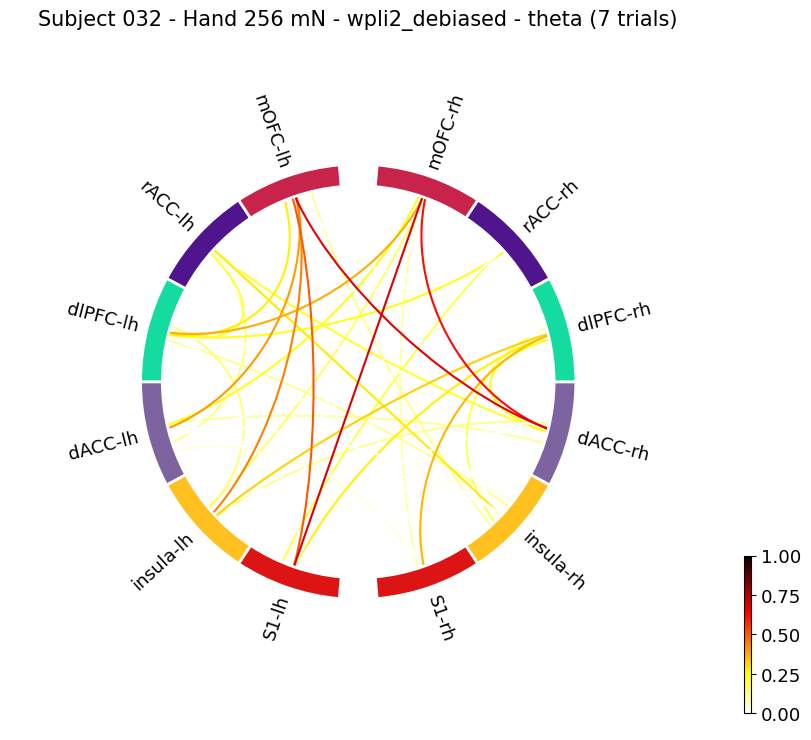

Hand 256 mN - 034 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+------------------------+----------+
|       Connection       | Strength |
+------------------------+----------+
|   dlPFC-lh <-> S1-lh   |  0.418   |
| dlPFC-lh <-> insula-lh |  0.244   |
|   rACC-rh <-> S1-lh    |  0.243   |
+------------------------+----------+
Num epochs: 10
+------------------------+----------------+
|        ROI Pair        | {method} Value |
+------------------------+----------------+
|   dlPFC-lh <-> S1-lh   |     0.418      |
| dlPFC-lh <-> insula-lh |     0.244      |
|   rACC-rh <-> S1-lh    |     0.243      |
+------------------------+----------------+


<Figure size 640x480 with 0 Axes>

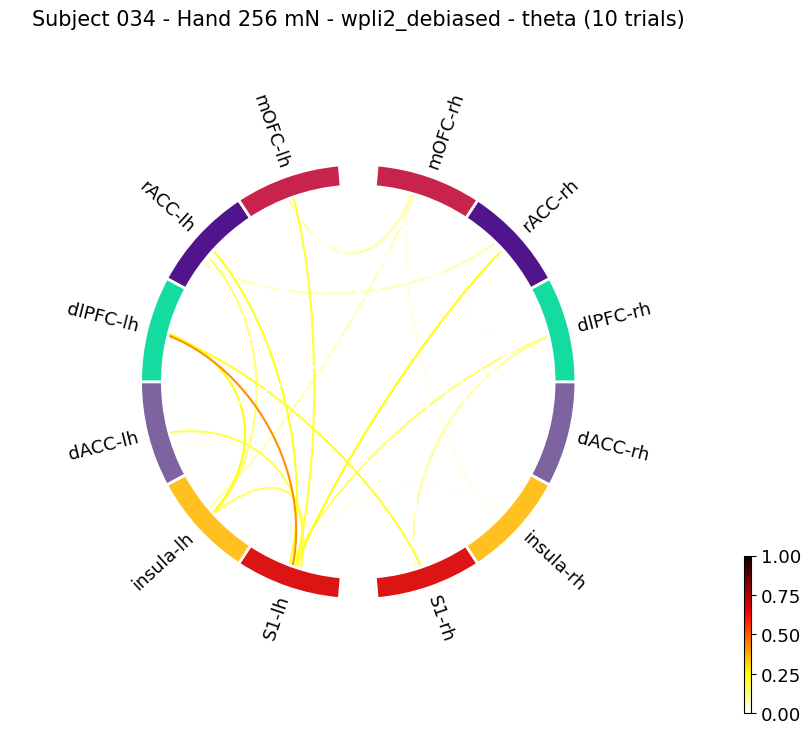

Hand 256 mN - 036 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+-----------------------+----------+
|      Connection       | Strength |
+-----------------------+----------+
|  dlPFC-rh <-> S1-rh   |  0.418   |
| insula-rh <-> rACC-lh |   0.23   |
| dACC-rh <-> dlPFC-lh  |  0.226   |
+-----------------------+----------+
Num epochs: 10
+-----------------------+----------------+
|       ROI Pair        | {method} Value |
+-----------------------+----------------+
|  dlPFC-rh <-> S1-rh   |     0.418      |
| insula-rh <-> rACC-lh |      0.23      |
| dACC-rh <-> dlPFC-lh  |     0.226      |
+-----------------------+----------------+


<Figure size 640x480 with 0 Axes>

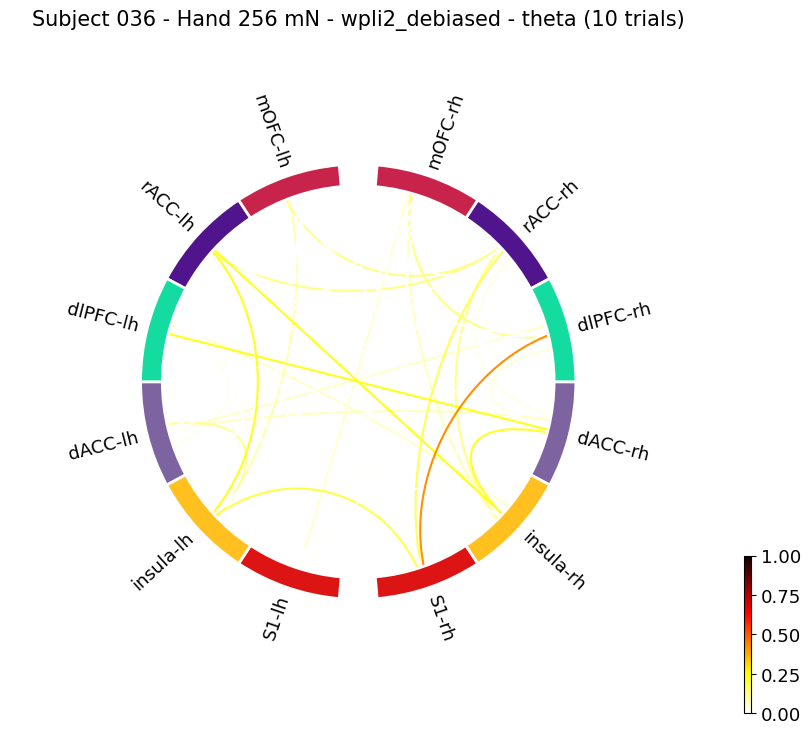

Hand 256 mN - 039 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+----------------------+----------+
|      Connection      | Strength |
+----------------------+----------+
| mOFC-rh <-> dACC-lh  |  0.766   |
| dlPFC-rh <-> rACC-lh |  0.486   |
| mOFC-rh <-> rACC-lh  |  0.472   |
+----------------------+----------+
Num epochs: 10
+----------------------+----------------+
|       ROI Pair       | {method} Value |
+----------------------+----------------+
| mOFC-rh <-> dACC-lh  |     0.766      |
| dlPFC-rh <-> rACC-lh |     0.486      |
| mOFC-rh <-> rACC-lh  |     0.472      |
+----------------------+----------------+


<Figure size 640x480 with 0 Axes>

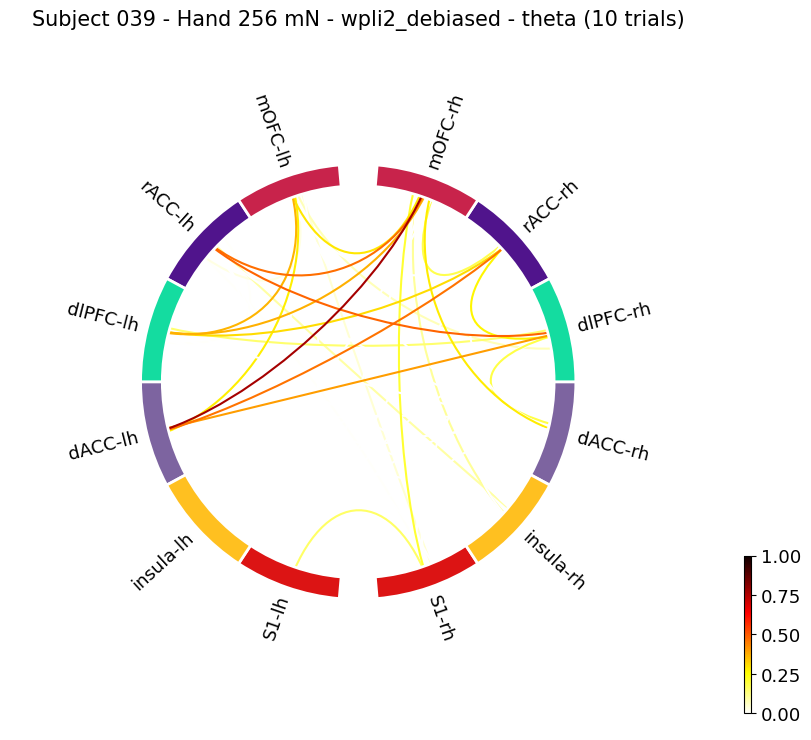

Hand 256 mN - 040 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+-----------------------+----------+
|      Connection       | Strength |
+-----------------------+----------+
| mOFC-rh <-> insula-lh |  0.544   |
| dlPFC-rh <-> dACC-lh  |  0.275   |
|   mOFC-rh <-> S1-rh   |  0.234   |
+-----------------------+----------+
Num epochs: 10
+-----------------------+----------------+
|       ROI Pair        | {method} Value |
+-----------------------+----------------+
| mOFC-rh <-> insula-lh |     0.544      |
| dlPFC-rh <-> dACC-lh  |     0.275      |
|   mOFC-rh <-> S1-rh   |     0.234      |
+-----------------------+----------------+


<Figure size 640x480 with 0 Axes>

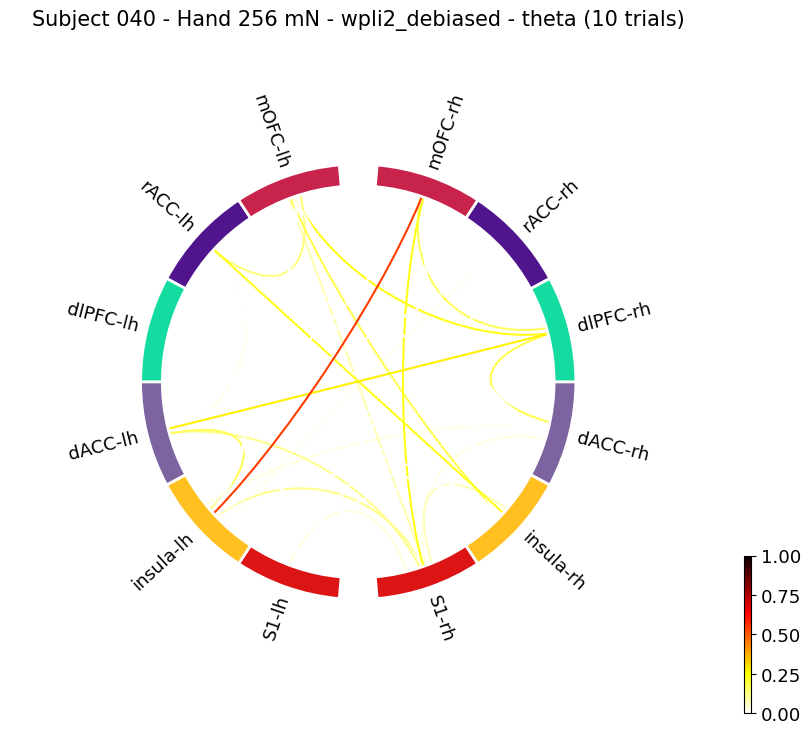

Hand 256 mN - 046 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+-----------------------+----------+
|      Connection       | Strength |
+-----------------------+----------+
|   rACC-rh <-> S1-lh   |  0.507   |
| insula-rh <-> mOFC-lh |   0.49   |
|  dlPFC-rh <-> S1-rh   |  0.465   |
+-----------------------+----------+
Num epochs: 9
+-----------------------+----------------+
|       ROI Pair        | {method} Value |
+-----------------------+----------------+
|   rACC-rh <-> S1-lh   |     0.507      |
| insula-rh <-> mOFC-lh |      0.49      |
|  dlPFC-rh <-> S1-rh   |     0.465      |
+-----------------------+----------------+


<Figure size 640x480 with 0 Axes>

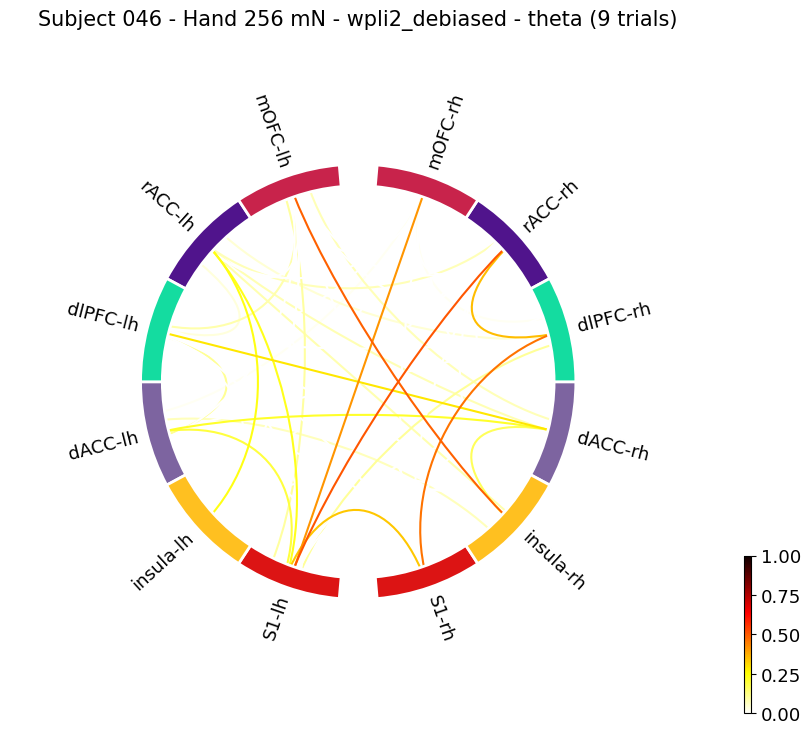

Hand 256 mN - 052 - CP w/ Widespread Pain - wpli2_debiased - theta
Top 3 Connections in CP w/ Widespread Pain group
+-------------------------+----------+
|       Connection        | Strength |
+-------------------------+----------+
| dlPFC-rh <-> insula-rh  |  0.586   |
|  insula-rh <-> rACC-lh  |  0.297   |
| insula-rh <-> insula-lh |  0.275   |
+-------------------------+----------+
Num epochs: 10
+-------------------------+----------------+
|        ROI Pair         | {method} Value |
+-------------------------+----------------+
| dlPFC-rh <-> insula-rh  |     0.586      |
|  insula-rh <-> rACC-lh  |     0.297      |
| insula-rh <-> insula-lh |     0.275      |
+-------------------------+----------------+


<Figure size 640x480 with 0 Axes>

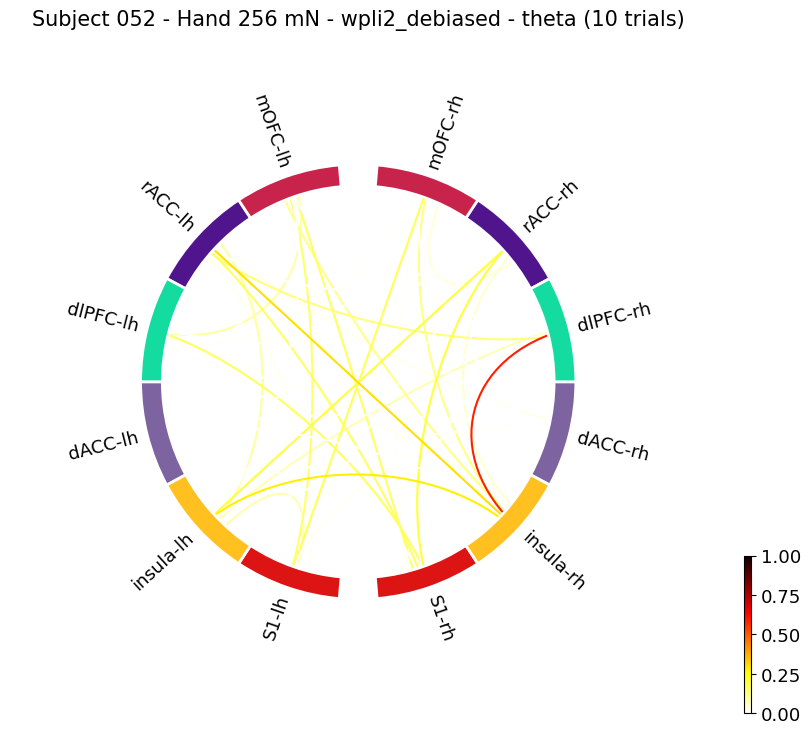

In [24]:
# CP Widespread Pain
this_group_name = "CP w/ Widespread Pain"
this_group_cons = sub_con_CP_WSP
n=len(roi_names)

for sub_id in this_group_cons:
    for condition in conditions:
        # Make a directory for the stats
        stats_save_path = save_path / f"CP_WSP_individual_{condition}"
        os.makedirs(stats_save_path, exist_ok=True)
        for method in con_methods:
            for band in band_names:
                # Select groups for mann-whitney
                print(f"{condition} - {sub_id} - {this_group_name} - {method} - {band}")
                
                # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
                table_data = []  
                top_3_info = this_group_cons[sub_id][condition][method][band]["top 3"] 
                print(f"Top 3 Connections in {this_group_name} group")
                for i in range(3):  
                    connection = top_3_info[i][0]  
                    strength = top_3_info[i][1]
                    table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", strength])  
                
                # Define table headers  
                headers = ['Connection', 'Strength']  
                
                # Print the table  
                print(tabulate(table_data, headers, tablefmt='pretty'))  

                group1_stack = this_group_cons[sub_id][condition][method][band]["data"]
                nepochs_1 = this_group_cons[sub_id][condition]['num_epochs']
                print(f"Num epochs: {nepochs_1}")

                # Plotting
                # Gather the information for plotting
                plot_kwargs= dict(
                    method=method,
                    band=band, 
                    roi_names=roi_names,
                    roi_acronyms=roi_acronyms,
                    condition=condition,
                    group_names=this_group_name,
                    nepochs=[nepochs_1],
                    titles=[f"Subject {sub_id} - {condition} - {method} - {band} ({nepochs_1} trials)"],
                    save_names=[this_group_name],
                    save_path=stats_save_path,
                    )
            
                fc.plot_connectivity_and_stats(
                    means_1=group1_stack,
                    **plot_kwargs,
                    save_fig=True,
                    highlight_pvals=highlight_pvals,
                    show_only_significant=show_only_significant,
                    min_fc_val=min_fc_val,
                    set_title=set_title,
                    show_fc_vals=show_fc_vals,
                    round_neg_vals=round_neg_vals,
                )

                if "aec" in method and plot_brain:
                    # Convert ROI names to labels
                    labels = [
                        mne.read_labels_from_annot(
                            subject, regexp=roi, subjects_dir=subjects_dir
                        )[0]
                        for roi in roi_names
                    ]

                    # Load the inverse
                    inv = None
                    if "Eyes" not in condition:
                        inv = utils.unpickle_data(zscored_epochs_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Open":
                        inv = utils.unpickle_data(EO_resting_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Closed":
                        inv = utils.unpickle_data(EC_resting_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )

                    fc.plot_degree(
                        p_values, 
                        title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_1, 
                        title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_2, 
                        title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )

In [25]:
top_3_info[0]

((10, 9), 0.586)